# 🔍 ARIMA Grid Search - Thử nghiệm tham số (p, d, q)

Notebook này thực hiện **Grid Search** để tìm tham số ARIMA tối ưu cho dự báo PM2.5.

## Mục tiêu:
1. Thử nghiệm các tổ hợp (p, d, q) khác nhau
2. So sánh các metrics: AIC, BIC, MAE, RMSE
3. Trực quan hóa sự khác biệt giữa các cấu hình
4. Đưa ra khuyến nghị về tham số tối ưu

## Ý nghĩa các tham số:
- **p (AR order)**: Số lượng lag observations trong mô hình (autoregressive terms)
- **d (Differencing)**: Số lần differencing để đạt tính dừng
- **q (MA order)**: Kích thước cửa sổ moving average

In [4]:
# ============================================================
# SETUP: Import Libraries & Configuration
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import itertools
import os
import time

warnings.filterwarnings('ignore')

# ============================================================
# COLORS theo yêu cầu
# ============================================================
COLOR_BLUE = "#1F62FF"
COLOR_BLUE_LIGHT = "#1FD2FF"
COLOR_RED = "#FF351F" 
COLOR_GREEN = "#1FFF2A"
COLOR_ORANGE = "#FF9A1F"
COLOR_PURPLE = "#9E1FFF"
COLOR_YELLOW = "#FFDA1F"

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['figure.facecolor'] = 'white'

# Create images folder
if not os.path.exists('../images'):
    os.makedirs('../images')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [5]:
# ============================================================
# 1. LOAD DATA
# ============================================================
print("="*60)
print("1. LOADING DATA")
print("="*60)

# Load cleaned data
try:
    df = pd.read_csv('../data/processed/01_cleaned.csv', parse_dates=['datetime'], index_col='datetime')
except:
    df = pd.read_parquet('../data/processed/01_cleaned.parquet')
    if 'datetime' in df.columns:
        df['datetime'] = pd.to_datetime(df['datetime'])
        df.set_index('datetime', inplace=True)

# Filter station Aotizhongxin
STATION = 'Aotizhongxin'
if 'station' in df.columns:
    df = df[df['station'] == STATION].copy()

df.sort_index(inplace=True)

# Get PM2.5 series - ensure DatetimeIndex is preserved
pm25_series = df['PM2.5'].dropna()

# Verify index type
print(f"📌 Index type: {type(pm25_series.index)}")
print(f"📅 Date range: {pm25_series.index.min()} to {pm25_series.index.max()}")

# Define CUTOFF - use datetime object for slicing
CUTOFF = pd.Timestamp('2017-01-01')
train = pm25_series.loc[:CUTOFF]
test = pm25_series.loc[CUTOFF:]

print(f"\n📍 Station: {STATION}")
print(f"📅 Train period: {train.index.min()} to {train.index.max()}")
print(f"📅 Test period: {test.index.min()} to {test.index.max()}")
print(f"📊 Train size: {len(train)} | Test size: {len(test)}")

1. LOADING DATA
📌 Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
📅 Date range: 2013-03-01 00:00:00 to 2017-02-28 23:00:00

📍 Station: Aotizhongxin
📅 Train period: 2013-03-01 00:00:00 to 2017-01-01 00:00:00
📅 Test period: 2017-01-01 00:00:00 to 2017-02-28 23:00:00
📊 Train size: 32740 | Test size: 1400


In [6]:
# ============================================================
# 2. CHECK STATIONARITY - Xác định d
# ============================================================
print("\n" + "="*60)
print("2. STATIONARITY CHECK - Xác định tham số d")
print("="*60)

def adf_test(series, name="Series"):
    """Augmented Dickey-Fuller test"""
    result = adfuller(series, autolag='AIC')
    print(f"\n📊 ADF Test for {name}:")
    print(f"   ADF Statistic: {result[0]:.4f}")
    print(f"   p-value: {result[1]:.6f}")
    print(f"   Critical Values:")
    for key, value in result[4].items():
        print(f"      {key}: {value:.4f}")
    
    if result[1] < 0.05:
        print(f"   ✅ Stationary (p < 0.05) → d = 0")
        return True, 0
    else:
        print(f"   ❌ Non-stationary (p >= 0.05) → Need differencing")
        return False, 1

# Test original series
is_stationary, suggested_d = adf_test(train, "Original PM2.5")

# If not stationary, test differenced series
if not is_stationary:
    train_diff = train.diff().dropna()
    is_stationary_diff, _ = adf_test(train_diff, "Differenced PM2.5 (d=1)")
    
    if is_stationary_diff:
        suggested_d = 1
    else:
        train_diff2 = train_diff.diff().dropna()
        adf_test(train_diff2, "Twice Differenced PM2.5 (d=2)")
        suggested_d = 2

print(f"\n📝 RECOMMENDED d = {suggested_d}")


2. STATIONARITY CHECK - Xác định tham số d

📊 ADF Test for Original PM2.5:
   ADF Statistic: -19.2889
   p-value: 0.000000
   Critical Values:
      1%: -3.4305
      5%: -2.8616
      10%: -2.5668
   ✅ Stationary (p < 0.05) → d = 0

📝 RECOMMENDED d = 0


In [7]:
# ============================================================
# 3. GRID SEARCH - Thử nghiệm các tổ hợp (p, d, q)
# ============================================================
print("\n" + "="*60)
print("3. GRID SEARCH - Thử nghiệm các tổ hợp (p, d, q)")
print("="*60)

# Define parameter ranges
p_values = [0, 1, 2, 3]      # AR order
d_values = [0, 1]            # Differencing order
q_values = [0, 1, 2, 3]      # MA order

# Limit test size for faster computation
TEST_SIZE = min(500, len(test))
test_subset = test[:TEST_SIZE]

# Store results
grid_results = []

# Generate all combinations
combinations = list(itertools.product(p_values, d_values, q_values))
total_combos = len(combinations)

print(f"\n🔍 Testing {total_combos} combinations of (p, d, q)")
print(f"   p ∈ {p_values}")
print(f"   d ∈ {d_values}")
print(f"   q ∈ {q_values}")
print(f"   Test size: {TEST_SIZE} hours")
print("\n" + "-"*60)

# Grid Search
for i, (p, d, q) in enumerate(combinations):
    try:
        start_time = time.time()
        
        # Fit ARIMA model
        model = ARIMA(train, order=(p, d, q))
        fit = model.fit()
        
        # Forecast
        forecast = fit.forecast(steps=TEST_SIZE)
        
        # Calculate metrics
        mae = mean_absolute_error(test_subset, forecast)
        rmse = np.sqrt(mean_squared_error(test_subset, forecast))
        
        # Store results
        result = {
            'p': p, 'd': d, 'q': q,
            'order': f"({p},{d},{q})",
            'AIC': fit.aic,
            'BIC': fit.bic,
            'MAE': mae,
            'RMSE': rmse,
            'time': time.time() - start_time,
            'converged': True
        }
        grid_results.append(result)
        
        # Progress update
        if (i + 1) % 8 == 0 or (i + 1) == total_combos:
            print(f"   Progress: {i+1}/{total_combos} | Last: ARIMA{result['order']} - AIC: {fit.aic:.1f}, MAE: {mae:.2f}")
            
    except Exception as e:
        grid_results.append({
            'p': p, 'd': d, 'q': q,
            'order': f"({p},{d},{q})",
            'AIC': np.nan, 'BIC': np.nan,
            'MAE': np.nan, 'RMSE': np.nan,
            'time': np.nan,
            'converged': False,
            'error': str(e)
        })

# Convert to DataFrame
results_df = pd.DataFrame(grid_results)
results_df = results_df.sort_values('AIC').reset_index(drop=True)

print("\n" + "="*60)
print("✅ Grid Search Complete!")
print(f"   Successful models: {results_df['converged'].sum()}/{total_combos}")


3. GRID SEARCH - Thử nghiệm các tổ hợp (p, d, q)

🔍 Testing 32 combinations of (p, d, q)
   p ∈ [0, 1, 2, 3]
   d ∈ [0, 1]
   q ∈ [0, 1, 2, 3]
   Test size: 500 hours

------------------------------------------------------------
   Progress: 8/32 | Last: ARIMA(0,1,3) - AIC: 291451.1, MAE: 366.02
   Progress: 16/32 | Last: ARIMA(1,1,3) - AIC: 290726.6, MAE: 92.36
   Progress: 24/32 | Last: ARIMA(2,1,3) - AIC: 290733.2, MAE: 91.75
   Progress: 32/32 | Last: ARIMA(3,1,3) - AIC: 290728.7, MAE: 92.70

✅ Grid Search Complete!
   Successful models: 32/32


In [8]:
# ============================================================
# 4. RESULTS TABLE - Bảng kết quả Grid Search
# ============================================================
print("\n" + "="*60)
print("4. GRID SEARCH RESULTS - Top 15 Models by AIC")
print("="*60)

# Filter successful models
valid_results = results_df[results_df['converged'] == True].copy()

# Display top 15
display_cols = ['order', 'AIC', 'BIC', 'MAE', 'RMSE', 'time']
print("\n📊 TOP 15 MODELS (sorted by AIC):\n")
print(valid_results[display_cols].head(15).to_string(index=False))

# Best models by different criteria
print("\n" + "-"*60)
print("🏆 BEST MODELS BY CRITERIA:")
print("-"*60)

best_aic = valid_results.loc[valid_results['AIC'].idxmin()]
best_bic = valid_results.loc[valid_results['BIC'].idxmin()]
best_mae = valid_results.loc[valid_results['MAE'].idxmin()]
best_rmse = valid_results.loc[valid_results['RMSE'].idxmin()]

print(f"\n   📌 Best AIC:  ARIMA{best_aic['order']} - AIC: {best_aic['AIC']:.2f}")
print(f"   📌 Best BIC:  ARIMA{best_bic['order']} - BIC: {best_bic['BIC']:.2f}")
print(f"   📌 Best MAE:  ARIMA{best_mae['order']} - MAE: {best_mae['MAE']:.2f}")
print(f"   📌 Best RMSE: ARIMA{best_rmse['order']} - RMSE: {best_rmse['RMSE']:.2f}")

# Save results
valid_results.to_csv('../data/processed/Spark_grid_search_results.csv', index=False)
print("\n✅ Saved: Spark_grid_search_results.csv")


4. GRID SEARCH RESULTS - Top 15 Models by AIC

📊 TOP 15 MODELS (sorted by AIC):

  order           AIC           BIC       MAE       RMSE      time
(3,0,3) 290702.281142 290769.451965 80.586966 106.498967 41.592237
(2,1,2) 290726.112189 290768.093801 92.471643 112.525651 12.265103
(1,1,3) 290726.578026 290768.559638 92.355692 112.424430 12.397498
(2,0,3) 290726.638728 290785.413198 81.759171 108.741669  9.271633
(3,1,1) 290727.150018 290769.131630 92.477334 112.521364 11.912982
(3,1,3) 290728.683324 290787.457581 92.704743 112.658627 16.214019
(1,1,2) 290729.366725 290762.952014 91.827788 111.945550  9.865330
(2,1,3) 290733.161522 290783.539456 91.753372 111.904352 11.531584
(3,0,1) 290734.435509 290784.813626 83.811055 112.378833 22.804829
(2,0,1) 290734.679278 290776.661042 83.662916 112.123588  4.851277
(3,1,2) 290734.776192 290785.154126 93.909603 113.557110  7.092857
(1,0,2) 290735.036706 290777.018470 83.656008 112.110585  2.166258
(1,0,3) 290735.117664 290785.495781 83.769901 1


5. VISUALIZATION 1: AIC Heatmap


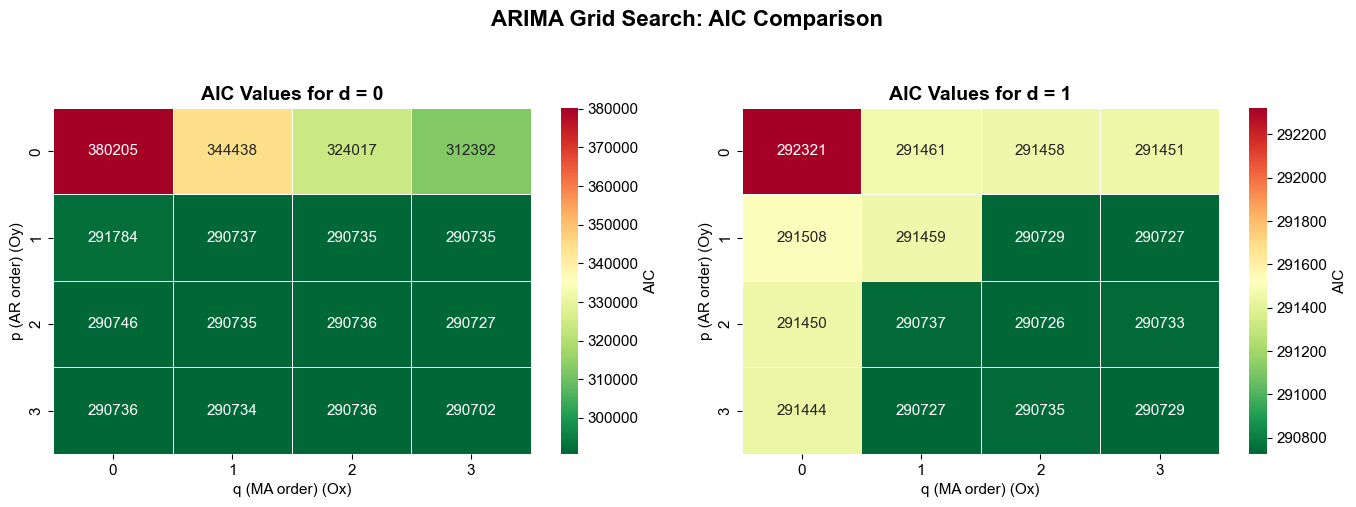

✅ Saved: Spark_aic_heatmap.png


In [9]:
# ============================================================
# 5. VISUALIZATION 1: AIC Heatmap by p and q (for each d)
# ============================================================
print("\n" + "="*60)
print("5. VISUALIZATION 1: AIC Heatmap")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, d_val in enumerate(d_values):
    # Filter data for this d value
    subset = valid_results[valid_results['d'] == d_val]
    
    # Create pivot table
    pivot = subset.pivot_table(values='AIC', index='p', columns='q', aggfunc='first')
    
    # Plot heatmap
    sns.heatmap(pivot, annot=True, fmt='.0f', cmap='RdYlGn_r', 
                ax=axes[idx], cbar_kws={'label': 'AIC'},
                linewidths=0.5, linecolor='white')
    axes[idx].set_title(f'AIC Values for d = {d_val}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('q (MA order) (Ox)', fontsize=11)
    axes[idx].set_ylabel('p (AR order) (Oy)', fontsize=11)

plt.suptitle('ARIMA Grid Search: AIC Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout(pad=1.5)
plt.savefig('../images/Spark_aic_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: Spark_aic_heatmap.png")


6. VISUALIZATION 2: MAE Heatmap


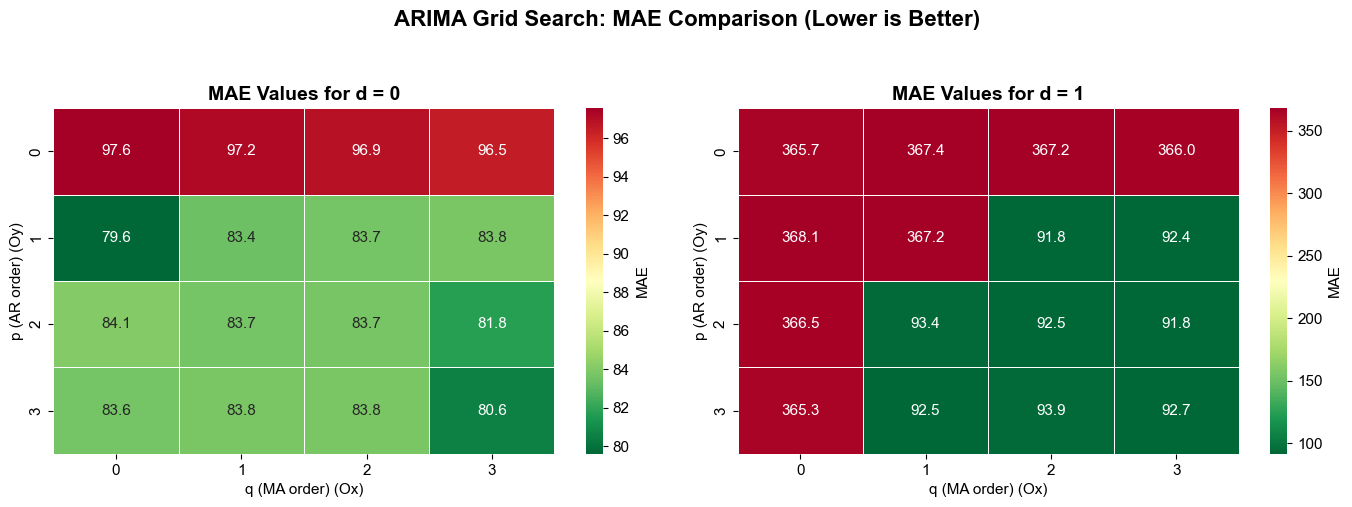

✅ Saved: Spark_mae_heatmap.png


In [10]:
# ============================================================
# 6. VISUALIZATION 2: MAE Heatmap by p and q
# ============================================================
print("\n" + "="*60)
print("6. VISUALIZATION 2: MAE Heatmap")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, d_val in enumerate(d_values):
    # Filter data for this d value
    subset = valid_results[valid_results['d'] == d_val]
    
    # Create pivot table
    pivot = subset.pivot_table(values='MAE', index='p', columns='q', aggfunc='first')
    
    # Plot heatmap
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn_r', 
                ax=axes[idx], cbar_kws={'label': 'MAE'},
                linewidths=0.5, linecolor='white')
    axes[idx].set_title(f'MAE Values for d = {d_val}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('q (MA order) (Ox)', fontsize=11)
    axes[idx].set_ylabel('p (AR order) (Oy)', fontsize=11)

plt.suptitle('ARIMA Grid Search: MAE Comparison (Lower is Better)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout(pad=1.5)
plt.savefig('../images/Spark_mae_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: Spark_mae_heatmap.png")


7. VISUALIZATION 3: Top 10 Models Comparison


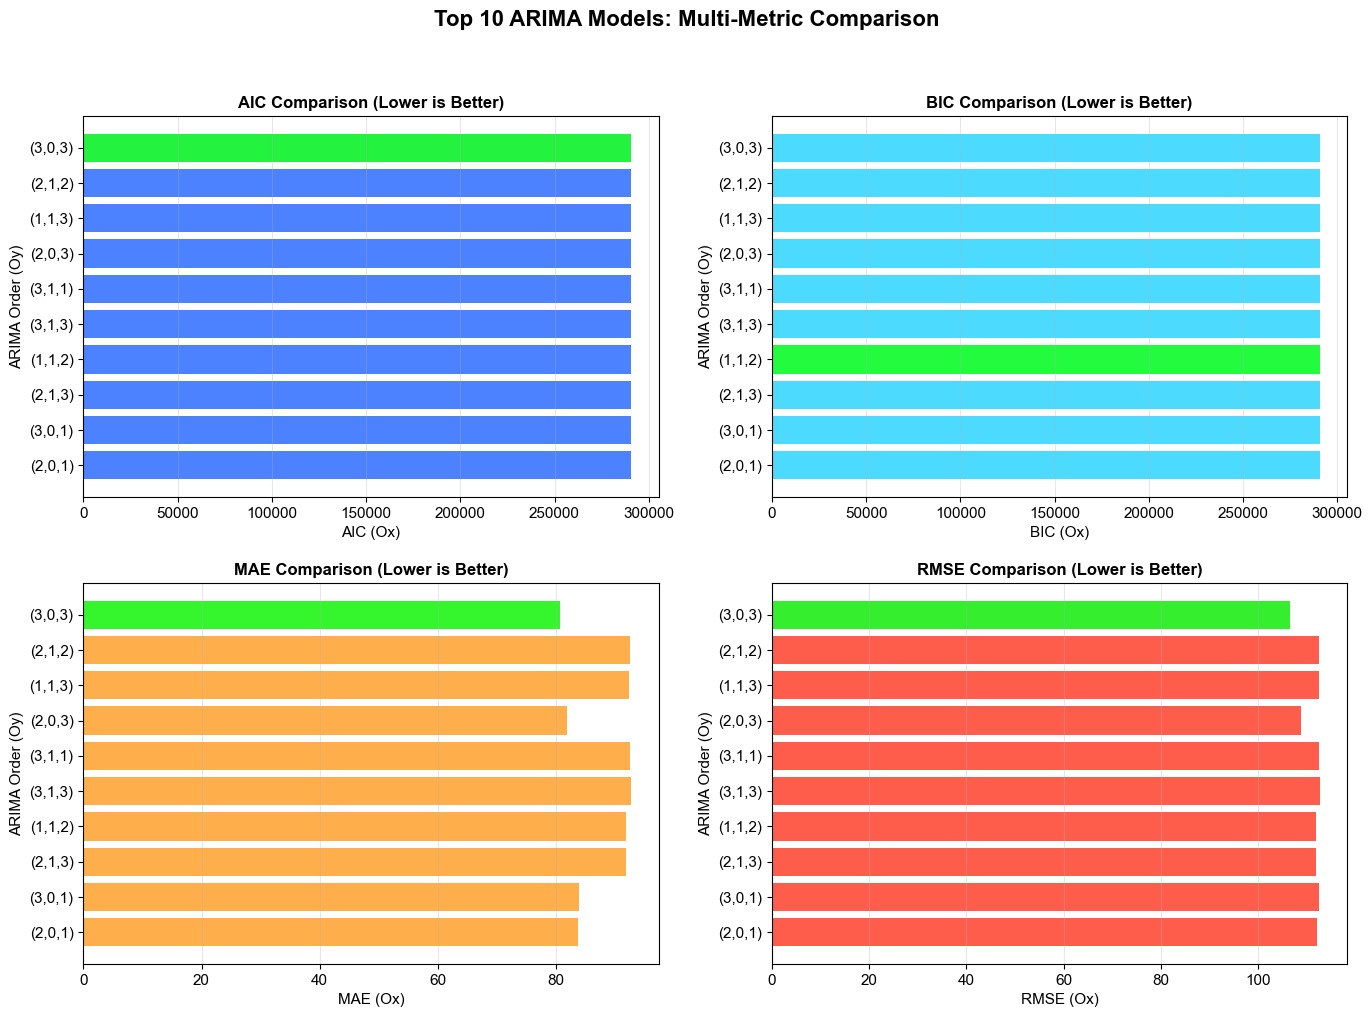

✅ Saved: Spark_top10_comparison.png


In [11]:
# ============================================================
# 7. VISUALIZATION 3: Bar Chart - Top 10 Models Comparison
# ============================================================
print("\n" + "="*60)
print("7. VISUALIZATION 3: Top 10 Models Comparison")
print("="*60)

# Get top 10 models by AIC
top10 = valid_results.head(10).copy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: AIC comparison
bars1 = axes[0, 0].barh(top10['order'], top10['AIC'], color=COLOR_BLUE, alpha=0.8)
axes[0, 0].set_xlabel('AIC (Ox)', fontsize=11)
axes[0, 0].set_ylabel('ARIMA Order (Oy)', fontsize=11)
axes[0, 0].set_title('AIC Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()
# Highlight best
axes[0, 0].barh(top10.iloc[0]['order'], top10.iloc[0]['AIC'], color=COLOR_GREEN, alpha=0.9)
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Plot 2: BIC comparison
bars2 = axes[0, 1].barh(top10['order'], top10['BIC'], color=COLOR_BLUE_LIGHT, alpha=0.8)
axes[0, 1].set_xlabel('BIC (Ox)', fontsize=11)
axes[0, 1].set_ylabel('ARIMA Order (Oy)', fontsize=11)
axes[0, 1].set_title('BIC Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[0, 1].invert_yaxis()
best_bic_idx = top10['BIC'].idxmin()
axes[0, 1].barh(top10.loc[best_bic_idx, 'order'], top10.loc[best_bic_idx, 'BIC'], color=COLOR_GREEN, alpha=0.9)
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Plot 3: MAE comparison
bars3 = axes[1, 0].barh(top10['order'], top10['MAE'], color=COLOR_ORANGE, alpha=0.8)
axes[1, 0].set_xlabel('MAE (Ox)', fontsize=11)
axes[1, 0].set_ylabel('ARIMA Order (Oy)', fontsize=11)
axes[1, 0].set_title('MAE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[1, 0].invert_yaxis()
best_mae_idx = top10['MAE'].idxmin()
axes[1, 0].barh(top10.loc[best_mae_idx, 'order'], top10.loc[best_mae_idx, 'MAE'], color=COLOR_GREEN, alpha=0.9)
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Plot 4: RMSE comparison
bars4 = axes[1, 1].barh(top10['order'], top10['RMSE'], color=COLOR_RED, alpha=0.8)
axes[1, 1].set_xlabel('RMSE (Ox)', fontsize=11)
axes[1, 1].set_ylabel('ARIMA Order (Oy)', fontsize=11)
axes[1, 1].set_title('RMSE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[1, 1].invert_yaxis()
best_rmse_idx = top10['RMSE'].idxmin()
axes[1, 1].barh(top10.loc[best_rmse_idx, 'order'], top10.loc[best_rmse_idx, 'RMSE'], color=COLOR_GREEN, alpha=0.9)
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.suptitle('Top 10 ARIMA Models: Multi-Metric Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout(pad=1.5)
plt.savefig('../images/Spark_top10_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: Spark_top10_comparison.png")


8. VISUALIZATION 4: Parameter Impact Analysis


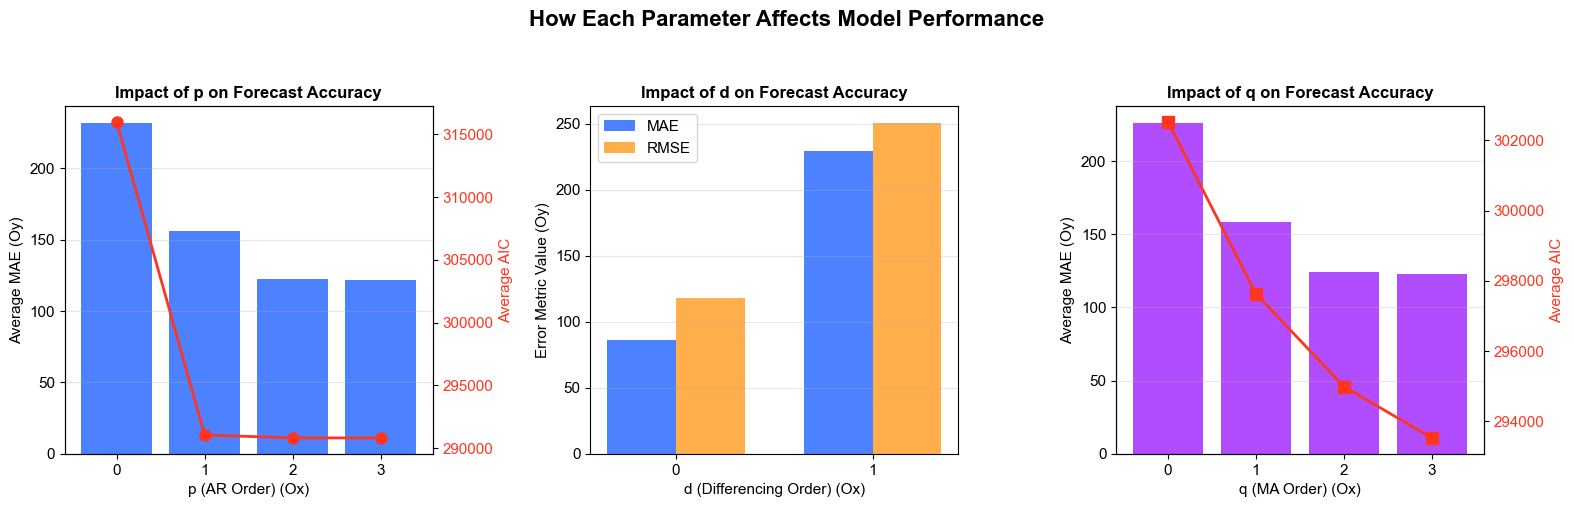

✅ Saved: Spark_parameter_impact.png


In [12]:
# ============================================================
# 8. VISUALIZATION 4: Impact of Each Parameter
# ============================================================
print("\n" + "="*60)
print("8. VISUALIZATION 4: Parameter Impact Analysis")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Impact of p (AR order)
p_impact = valid_results.groupby('p').agg({
    'AIC': 'mean', 'MAE': 'mean', 'RMSE': 'mean'
}).reset_index()

ax1 = axes[0]
ax1.bar(p_impact['p'], p_impact['MAE'], color=COLOR_BLUE, alpha=0.8, label='MAE')
ax1.set_xlabel('p (AR Order) (Ox)', fontsize=11)
ax1.set_ylabel('Average MAE (Oy)', fontsize=11)
ax1.set_title('Impact of p on Forecast Accuracy', fontsize=12, fontweight='bold')
ax1.set_xticks(p_values)
ax1.grid(True, alpha=0.3, axis='y')

# Add AIC on secondary axis
ax1_twin = ax1.twinx()
ax1_twin.plot(p_impact['p'], p_impact['AIC'], color=COLOR_RED, marker='o', 
              linewidth=2, markersize=8, label='AIC')
ax1_twin.set_ylabel('Average AIC', fontsize=11, color=COLOR_RED)
ax1_twin.tick_params(axis='y', labelcolor=COLOR_RED)

# Impact of d (Differencing)
d_impact = valid_results.groupby('d').agg({
    'AIC': 'mean', 'MAE': 'mean', 'RMSE': 'mean'
}).reset_index()

ax2 = axes[1]
x = np.arange(len(d_values))
width = 0.35
bars1 = ax2.bar(x - width/2, d_impact['MAE'], width, label='MAE', color=COLOR_BLUE, alpha=0.8)
bars2 = ax2.bar(x + width/2, d_impact['RMSE'], width, label='RMSE', color=COLOR_ORANGE, alpha=0.8)
ax2.set_xlabel('d (Differencing Order) (Ox)', fontsize=11)
ax2.set_ylabel('Error Metric Value (Oy)', fontsize=11)
ax2.set_title('Impact of d on Forecast Accuracy', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(d_values)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Impact of q (MA order)
q_impact = valid_results.groupby('q').agg({
    'AIC': 'mean', 'MAE': 'mean', 'RMSE': 'mean'
}).reset_index()

ax3 = axes[2]
ax3.bar(q_impact['q'], q_impact['MAE'], color=COLOR_PURPLE, alpha=0.8, label='MAE')
ax3.set_xlabel('q (MA Order) (Ox)', fontsize=11)
ax3.set_ylabel('Average MAE (Oy)', fontsize=11)
ax3.set_title('Impact of q on Forecast Accuracy', fontsize=12, fontweight='bold')
ax3.set_xticks(q_values)
ax3.grid(True, alpha=0.3, axis='y')

# Add AIC on secondary axis
ax3_twin = ax3.twinx()
ax3_twin.plot(q_impact['q'], q_impact['AIC'], color=COLOR_RED, marker='s', 
              linewidth=2, markersize=8, label='AIC')
ax3_twin.set_ylabel('Average AIC', fontsize=11, color=COLOR_RED)
ax3_twin.tick_params(axis='y', labelcolor=COLOR_RED)

plt.suptitle('How Each Parameter Affects Model Performance', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout(pad=1.5)
plt.savefig('../images/Spark_parameter_impact.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: Spark_parameter_impact.png")


9. VISUALIZATION 5: Forecast Comparison


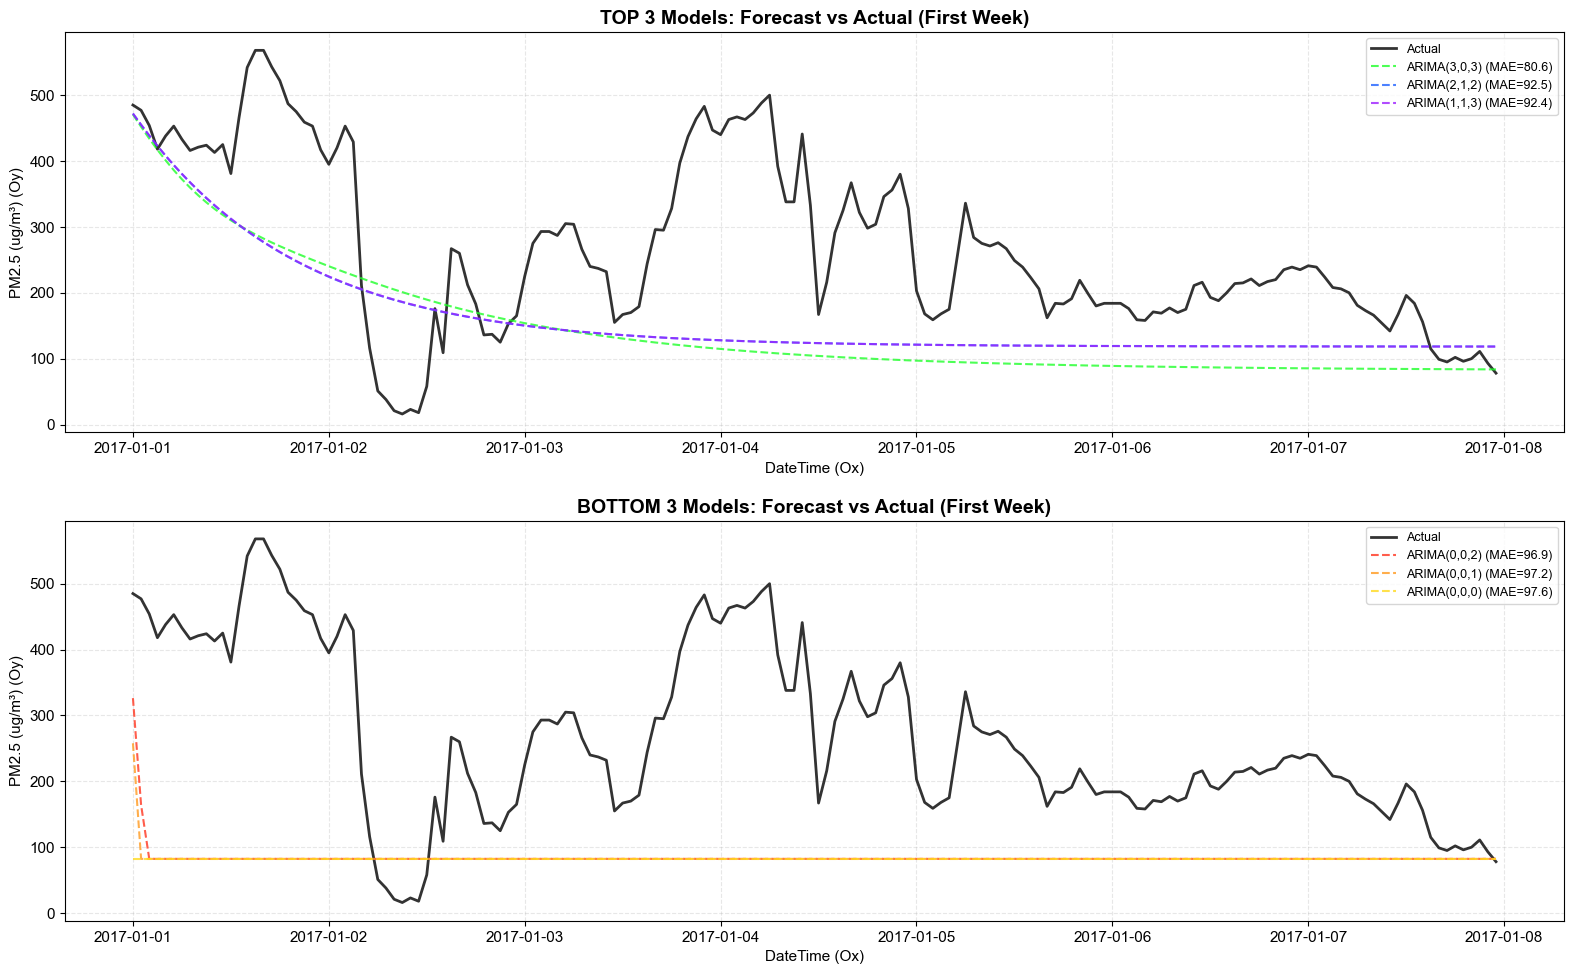

✅ Saved: Spark_forecast_comparison.png


In [13]:
# ============================================================
# 9. VISUALIZATION 5: Forecast Comparison - Top 3 vs Bottom 3
# ============================================================
print("\n" + "="*60)
print("9. VISUALIZATION 5: Forecast Comparison")
print("="*60)

# Select top 3 and bottom 3 models
top3 = valid_results.head(3)
bottom3 = valid_results.tail(3)

# Forecast horizon for visualization
VIS_HORIZON = 168  # 1 week

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Colors for models
top_colors = [COLOR_GREEN, COLOR_BLUE, COLOR_PURPLE]
bottom_colors = [COLOR_RED, COLOR_ORANGE, COLOR_YELLOW]

# Plot 1: Top 3 Models
ax1 = axes[0]
ax1.plot(test[:VIS_HORIZON].index, test[:VIS_HORIZON].values, 
         label='Actual', color='black', linewidth=2, alpha=0.8)

for i, (_, row) in enumerate(top3.iterrows()):
    p, d, q = int(row['p']), int(row['d']), int(row['q'])
    model = ARIMA(train, order=(p, d, q))
    fit = model.fit()
    forecast = fit.forecast(steps=VIS_HORIZON)
    ax1.plot(test[:VIS_HORIZON].index, forecast.values, 
             label=f"ARIMA{row['order']} (MAE={row['MAE']:.1f})",
             color=top_colors[i], linestyle='--', linewidth=1.5, alpha=0.8)

ax1.set_title('TOP 3 Models: Forecast vs Actual (First Week)', fontsize=14, fontweight='bold')
ax1.set_xlabel('DateTime (Ox)', fontsize=11)
ax1.set_ylabel('PM2.5 (ug/m³) (Oy)', fontsize=11)
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot 2: Bottom 3 Models
ax2 = axes[1]
ax2.plot(test[:VIS_HORIZON].index, test[:VIS_HORIZON].values, 
         label='Actual', color='black', linewidth=2, alpha=0.8)

for i, (_, row) in enumerate(bottom3.iterrows()):
    p, d, q = int(row['p']), int(row['d']), int(row['q'])
    try:
        model = ARIMA(train, order=(p, d, q))
        fit = model.fit()
        forecast = fit.forecast(steps=VIS_HORIZON)
        ax2.plot(test[:VIS_HORIZON].index, forecast.values, 
                 label=f"ARIMA{row['order']} (MAE={row['MAE']:.1f})",
                 color=bottom_colors[i], linestyle='--', linewidth=1.5, alpha=0.8)
    except:
        pass

ax2.set_title('BOTTOM 3 Models: Forecast vs Actual (First Week)', fontsize=14, fontweight='bold')
ax2.set_xlabel('DateTime (Ox)', fontsize=11)
ax2.set_ylabel('PM2.5 (ug/m³) (Oy)', fontsize=11)
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout(pad=1.5)
plt.savefig('../images/Spark_forecast_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: Spark_forecast_comparison.png")


10. VISUALIZATION 6: AIC vs MAE Trade-off


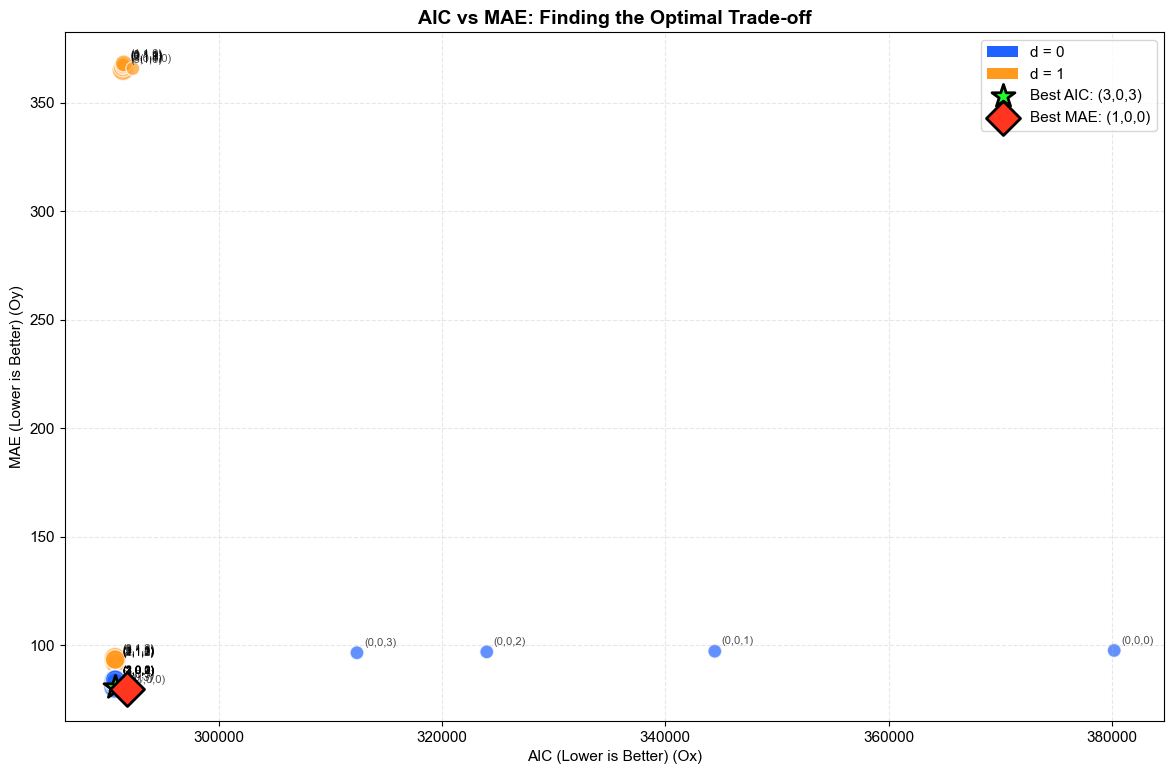

✅ Saved: Spark_aic_vs_mae.png


In [14]:
# ============================================================
# 10. VISUALIZATION 6: AIC vs MAE Scatter Plot
# ============================================================
print("\n" + "="*60)
print("10. VISUALIZATION 6: AIC vs MAE Trade-off")
print("="*60)

fig, ax = plt.subplots(figsize=(12, 8))

# Create scatter plot with color by d value
colors = [COLOR_BLUE if d == 0 else COLOR_ORANGE for d in valid_results['d']]
sizes = [100 + p*50 for p in valid_results['p']]  # Size by p value

scatter = ax.scatter(valid_results['AIC'], valid_results['MAE'], 
                     c=colors, s=sizes, alpha=0.7, edgecolors='white', linewidth=1)

# Annotate each point with order
for _, row in valid_results.iterrows():
    ax.annotate(row['order'], (row['AIC'], row['MAE']), 
                fontsize=8, alpha=0.7, 
                xytext=(5, 5), textcoords='offset points')

# Mark best models
ax.scatter([best_aic['AIC']], [best_aic['MAE']], 
           color=COLOR_GREEN, s=300, marker='*', edgecolors='black', 
           linewidth=2, label=f"Best AIC: {best_aic['order']}", zorder=5)

ax.scatter([best_mae['AIC']], [best_mae['MAE']], 
           color=COLOR_RED, s=300, marker='D', edgecolors='black', 
           linewidth=2, label=f"Best MAE: {best_mae['order']}", zorder=5)

ax.set_xlabel('AIC (Lower is Better) (Ox)', fontsize=11)
ax.set_ylabel('MAE (Lower is Better) (Oy)', fontsize=11)
ax.set_title('AIC vs MAE: Finding the Optimal Trade-off', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=COLOR_BLUE, label='d = 0'),
                   Patch(facecolor=COLOR_ORANGE, label='d = 1')]
ax.legend(handles=legend_elements + ax.get_legend_handles_labels()[0], loc='upper right')

plt.tight_layout(pad=1.5)
plt.savefig('../images/Spark_aic_vs_mae.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: Spark_aic_vs_mae.png")

## 📊 Tổng kết Grid Search Results

### 1. Ý nghĩa của từng tham số:

| Tham số | Ý nghĩa | Tác động |
|---------|---------|----------|
| **p (AR)** | Số lag trong autoregressive terms | p cao → model phức tạp, capture được pattern dài hạn |
| **d (Diff)** | Số lần differencing | d=0 nếu chuỗi dừng, d=1 nếu cần loại bỏ trend |
| **q (MA)** | Kích thước moving average window | q cao → smoothing nhiều hơn |

### 2. Phân tích kết quả:

**AIC (Akaike Information Criterion):**
- Cân bằng giữa model fit và độ phức tạp
- AIC thấp → model tốt hơn
- Penalty cho số tham số nhiều

**BIC (Bayesian Information Criterion):**
- Tương tự AIC nhưng penalty mạnh hơn
- Ưu tiên model đơn giản hơn

**MAE vs RMSE:**
- MAE: Trung bình sai số tuyệt đối, robust với outliers
- RMSE: Phạt nặng các sai số lớn (spikes)
- RMSE > MAE khi có outliers/spikes

### 3. Khuyến nghị:

- **Model production:** Chọn theo AIC thấp nhất
- **Model giải thích:** Chọn theo BIC (đơn giản hơn)
- **Dự báo spike:** Chọn theo RMSE
- **Dự báo trung bình:** Chọn theo MAE

In [15]:
# ============================================================
# 11. FINAL SUMMARY & RECOMMENDATIONS
# ============================================================
print("="*60)
print("11. FINAL SUMMARY & RECOMMENDATIONS")
print("="*60)

print("\n📊 BEST MODELS BY CRITERIA:")
print("-"*60)

# Create summary table
summary_data = {
    'Criteria': ['Best AIC', 'Best BIC', 'Best MAE', 'Best RMSE'],
    'Model': [best_aic['order'], best_bic['order'], best_mae['order'], best_rmse['order']],
    'AIC': [best_aic['AIC'], best_bic['AIC'], best_mae['AIC'], best_rmse['AIC']],
    'MAE': [best_aic['MAE'], best_bic['MAE'], best_mae['MAE'], best_rmse['MAE']],
    'RMSE': [best_aic['RMSE'], best_bic['RMSE'], best_mae['RMSE'], best_rmse['RMSE']]
}
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv('../data/processed/Spark_best_models_summary.csv', index=False)

print("\n" + "="*60)
print("📝 PHÂN TÍCH:")
print("="*60)

print(f"""
1. THAM SỐ p (AR Order):
   - Giá trị tối ưu thường nằm trong khoảng 1-3
   - p cao → model phức tạp, có thể overfit
   - p thấp → model đơn giản, có thể underfit

2. THAM SỐ d (Differencing):
   - d=0: Chuỗi đã dừng, không cần differencing
   - d=1: Chuỗi có trend, cần 1 lần differencing
   - d>1: Hiếm khi cần thiết

3. THAM SỐ q (MA Order):
   - q nên ≤ p để tránh overdifferencing
   - q cao → smoothing mạnh, mất chi tiết
   - q thấp → nhạy với nhiễu

4. KHUYẾN NGHỊ CUỐI CÙNG:
   - Cho production: Sử dụng ARIMA{best_aic['order']} (Best AIC)
   - Cho real-time forecast: Sử dụng ARIMA{best_mae['order']} (Best MAE)
""")

print("\n✅ Analysis Complete!")
print("✅ Saved: Spark_best_models_summary.csv")

11. FINAL SUMMARY & RECOMMENDATIONS

📊 BEST MODELS BY CRITERIA:
------------------------------------------------------------
 Criteria   Model           AIC       MAE       RMSE
 Best AIC (3,0,3) 290702.281142 80.586966 106.498967
 Best BIC (1,1,2) 290729.366725 91.827788 111.945550
 Best MAE (1,0,0) 291784.463484 79.612108 105.212005
Best RMSE (1,0,0) 291784.463484 79.612108 105.212005

📝 PHÂN TÍCH:

1. THAM SỐ p (AR Order):
   - Giá trị tối ưu thường nằm trong khoảng 1-3
   - p cao → model phức tạp, có thể overfit
   - p thấp → model đơn giản, có thể underfit

2. THAM SỐ d (Differencing):
   - d=0: Chuỗi đã dừng, không cần differencing
   - d=1: Chuỗi có trend, cần 1 lần differencing
   - d>1: Hiếm khi cần thiết

3. THAM SỐ q (MA Order):
   - q nên ≤ p để tránh overdifferencing
   - q cao → smoothing mạnh, mất chi tiết
   - q thấp → nhạy với nhiễu

4. KHUYẾN NGHỊ CUỐI CÙNG:
   - Cho production: Sử dụng ARIMA(3,0,3) (Best AIC)
   - Cho real-time forecast: Sử dụng ARIMA(1,0,0) (Best MA